# Machine Learning HW2

## Read Training Set

In [1]:
import numpy as np
import pandas as pd

In [2]:
train_file = 'data/X_train'
label_file = 'data/Y_train'
test_file = 'data/X_test'

with open(train_file, 'r') as f:
    next(f) # 跳过首行表头
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
with open(label_file, 'r') as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype = float)
with open(test_file, 'r') as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)

### Normalization

In [34]:
def normalize(X, train = True, normal_column = None):
    # This function normalize specific colunms of X
    # 
    # Arguments:
    #     X: data to be processed
    #     train: Boolean,'True' when processing traning data,'False' when not
    #     normal_column: indexes of the colunms that will be normalized.If 'None' when all of colunms will be normalized
    # Outputs:
    #     X: nomarlized data
    #     X_mean: computed mean value of training data
    #     X_std: computed standard deviation of training data

    if not normal_column:
        normal_column = np.arange(X.shape[1])
    if train:
        X_mean = np.mean(X[:,normal_column], axis = 0).reshape(1, -1)
        X_std = np.std(X[:,normal_column], axis = 0).reshape(1, -1)
    print(X_mean.shape,X_std.shape)
    X[:,normal_column] = (X[:,normal_column] - X_mean) / X_std
    return X, X_mean, X_std

In [36]:
def normalize(x_data):
    
    x_mean = np.mean(x_data, axis = 0)
    x_std = np.std(x_data, axis = 0)
    for i in range(len(x_data)):
        for j in range(len(x_data[i])):
            if x_std[j]:
                x_data[i][j] = (x_data[i][j] - x_mean[j]) / x_std[j]
                if x_std[j] == 0:
                    print('normalize wrong')
    return x_data,x_mean,x_std

### Shuffle

In [4]:
def shuffle(X, Y):
    # This function shuffles two equal-length list/array, X and Y, together.

    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    return X[randomize], Y[randomize]

### Diveid train and val

In [5]:
def train_dev_divide(X, Y, div_ratio = 0.2):
    # This function normalize specific colunms of X

    train_size = int(len(X) * (1 - div_ratio))
    return X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]

### Data preprocessing

In [37]:
X, Y = shuffle(X_train, Y_train)
X, _, _ = normalize(X)
train_X, train_y, val_X, val_y = train_dev_divide(X, Y)

In [38]:
train_size = train_X.shape[0]
val_size = val_X.shape[0]
params_size = train_X.shape[1]
print(train_X.shape)

(43404, 510)


## Training
**Logistic Regression & Adam**

### Sigmoid function

In [8]:
def sigmoid_func(z):
    # Sigmoid function can be used to calculate probability.
    # To avoid overflow, minimum/maximum output value is set.
    return 1 / (1 + np.exp(-z))

### Adam

In [183]:
params = int(params_size+1)

w = np.matrix(np.zeros([params,1]))
X = np.matrix(np.concatenate((np.ones([train_size,1]), train_X), axis = 1).astype(float))
train_y =train_y.reshape(-1,1)
Y = np.matrix(train_y)

# Initialize the parameters of the training
iteration = 10
learning_rate = 0.00001
batch_size = 128
loss = 0

# Initialize the parameters of the adam
p_1 = 0.9
p_2 = 0.999
eps = 1e-8
s = np.matrix(np.zeros([params,1]))
r = np.matrix(np.zeros([params,1]))

train_loss = []

for i in range(iteration):
    # Mini Batch
    for idx in range(int(train_size / batch_size)):
        batch_x = X[idx * batch_size: (idx+1)*batch_size,:]
        batch_y = train_y[idx * batch_size: (idx+1)*batch_size]
        loss += np.sum(np.multiply(-batch_y, np.log(sigmoid_func(batch_x * w))) - np.multiply(1 - batch_y,np.log(1 - sigmoid_func(batch_x * w)))) / batch_size
        if (idx+1)%60 == 0 :
            train_loss.append(loss/60)
            loss = 0
    
        gradient = (batch_x.T * (sigmoid_func(batch_x * w) - batch_y))/ batch_size

        s = p_1 * s + (1-p_1) * gradient
        r = p_2 * r + (1-p_2) * np.power(gradient, 2)

        s_gradient = s / (1 - p_1)
        r_gradient = r / (1 - p_2)
        
        w = w - np.multiply(learning_rate / (np.sqrt(r_gradient) + eps), s_gradient)
    loss = 0


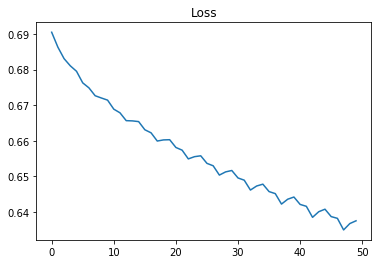

In [184]:
import matplotlib.pyplot as plt

# Loss curve
plt.plot(train_loss)
plt.title('Loss')
plt.show()